In [1]:
import pandas as pd
from NEExT.io import GraphIO
import igraph as ig
from matplotlib import pyplot as plt
import numpy as np

from NEExT.collections.egonet_collection import EgonetCollection
from NEExT.features.structural_node_features import StructuralNodeFeatures
from NEExT.features.node_features import NodeFeatures
from NEExT.builders.embedding_builder import EmbeddingBuilder
import seaborn as sns

%reload_ext autoreload
%autoreload 2

/home/quak/development/NEExT/.venv/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
edges_df = pd.read_csv("data/karate-mirrored", delimiter=" ", header=None)
edges_df.columns = ["src_node_id", "dest_node_id"]
edges_df["src_node_id"] -= 1
edges_df["dest_node_id"] -= 1
nodes = list(set(edges_df["src_node_id"].unique().tolist() + edges_df["dest_node_id"].unique().tolist()))
features_df = pd.DataFrame()
features_df["node_id"] = nodes

# for this problem we want to color code mirrored nodes
features_df["is_outlier"] = np.select(
    [
        (features_df["node_id"]+1).isin([1, 37]),
        (features_df["node_id"]+1).isin([2, 39]),
        (features_df["node_id"]+1).isin([3, 38]),
        (features_df["node_id"]+1).isin([33, 51]),
        (features_df["node_id"]+1).isin([34, 42]),
        (features_df["node_id"]+1).isin([17, 52]),
        (features_df["node_id"]+1).isin([12, 67]),
        (features_df["node_id"]+1).isin([25, 44]),
        (features_df["node_id"]+1).isin([26, 46]),
    ],
    [1, 2,3,4,5,6,7,8,9],
    0,
)
# features_df["is_outlier"] = np.where(np.array(ig.Graph(edges_df.values).degree())> 2, 1, 0)
# features_df.loc[[1,2,3,6,7,8,9], "is_outlier"] = 1

mapping_df = pd.DataFrame()
mapping_df["node_id"] = nodes
mapping_df["graph_id"] = 0

In [3]:
graph_io = GraphIO()
graph_collection = graph_io.load_from_dfs(
    edges_df=edges_df,
    node_graph_df=mapping_df,
    node_features_df=features_df,
    graph_type="igraph",
    filter_largest_component=False,
)

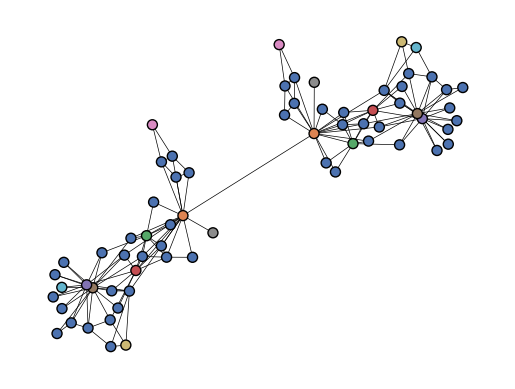

In [6]:
graph = graph_collection.graphs[0].G
# node_colors = graph.vs['is_outlier']
palette = sns.color_palette("deep", n_colors=10)

node_colors = [palette[int(node['is_outlier'])] for node in graph.vs]
edge_colors = ["black" for _ in graph.es]
layout = graph.layout("fr")

visual_style = {}
visual_style["vertex_size"] = 10
visual_style["vertex_color"] = node_colors
visual_style["edge_color"] = edge_colors
visual_style["edge_width"] = 0.5
visual_style["layout"] = layout
visual_style["vertex_label"] = None
visual_style["bbox"] = (600, 600)
visual_style["margin"] = 20


fig, ax = plt.subplots()
ig.plot(graph, target=ax, **visual_style)
plt.show()

In [9]:
# the caputring if the specific nodes has an outlier in its neighborhood
k_hop = 2
outlier_in_neighborhood = []

outlier_nodes = features_df.query("is_outlier == 1")["node_id"].tolist()
for node in range(graph.vcount()):
    neighbors = list(i for i in graph.neighborhood(node, order=k_hop) if i != node)
    # print(node, neighbors)
    if any(n in outlier_nodes for n in neighbors):
        outlier_in_neighborhood.append(1)
    elif node in outlier_nodes:
        outlier_in_neighborhood.append(2)
    else:
        outlier_in_neighborhood.append(0)
        
# outlier_in_neighborhood

In [13]:
global_structural_node_features = StructuralNodeFeatures(
    graph_collection=graph_collection,
    suffix="global",
    feature_list=['all'],#["degree_centrality", 'betastar'],
    feature_vector_length=2,
    n_jobs=1,
).compute()
graph_collection.add_node_features(global_structural_node_features.features_df)

egonet_collection = EgonetCollection(skip_features=["is_outlier"])
egonet_collection.compute_k_hop_egonets(graph_collection, k_hop, sample_fraction=1)
egonet_sampled_nodes = [graph.original_node_id for graph in egonet_collection.graphs]
################################
node_features = NodeFeatures(
    egonet_collection,
    feature_list=global_structural_node_features.feature_columns,
    n_jobs=1,
)
global_features = node_features.compute()
############################
emb_builder = EmbeddingBuilder(
    graph_collection=egonet_collection,
    # structural_features=structural_features,
    features=global_features,
    embeddings_dimension=5,
)
embeddings = emb_builder.compute("feature_embeddings")

Computing structural node features:   0%|          | 0/1 [00:00<?, ?it/s]

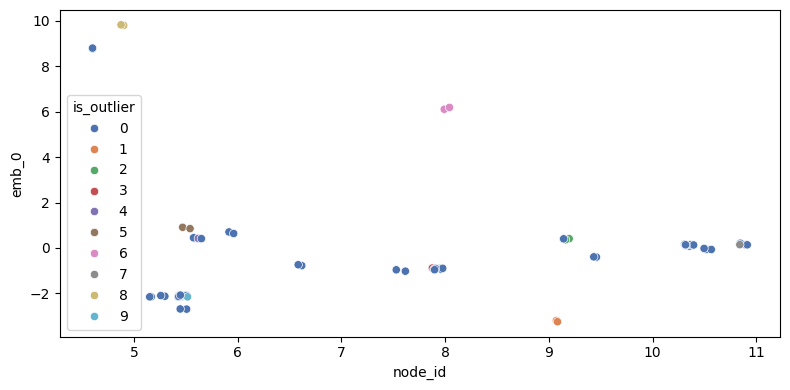

In [14]:
jitter_amount = 0.05
x = embeddings.embeddings_df.iloc[:, 1]
y = embeddings.embeddings_df.iloc[:, 2]
x += np.random.uniform(-jitter_amount, jitter_amount, size=len(x))
y += np.random.uniform(-jitter_amount, jitter_amount, size=len(y))



fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.scatterplot(
    x=x,
    y=y,
    hue=features_df['is_outlier'],
    # hue=np.array(outlier_in_neighborhood)[egonet_sampled_nodes],
    ax=ax,
    palette='deep',
)
ax.set_xlabel("node_id")
ax.set_ylabel("emb_0")
fig.tight_layout()

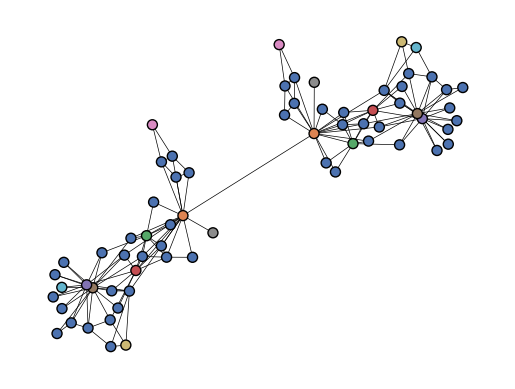

In [15]:
fig, ax = plt.subplots()
ig.plot(graph, target=ax, **visual_style)
plt.show()

/home/quak/development/NEExT/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


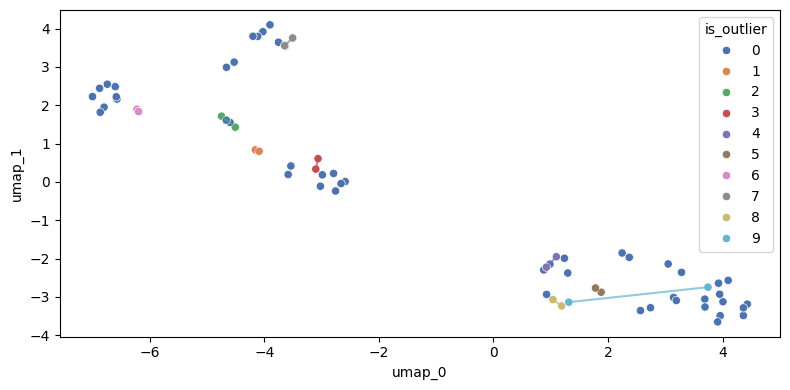

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import umap

reduced = make_pipeline(StandardScaler(), umap.UMAP(n_components=2)).fit_transform(embeddings.embeddings_df.values[:, 1:])
x = reduced[:, 0]
y = reduced[:, 1]
# x += np.random.uniform(-jitter_amount, jitter_amount, size=len(x))
# y += np.random.uniform(-jitter_amount, jitter_amount, size=len(y))



fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.scatterplot(
    x=x,
    y=y,
    hue=features_df['is_outlier'],
    # hue=np.array(outlier_in_neighborhood)[egonet_sampled_nodes],
    ax=ax,
    palette='deep',
)
ax.set_xlabel("umap_0")
ax.set_ylabel("umap_1")
for i in sorted(features_df.is_outlier.unique())[1:]:
    index = features_df.query(f'is_outlier=={i}').index.values
    ax.plot(x[index], y[index], color=palette[i], alpha=0.7)
    
fig.tight_layout()

/home/quak/development/NEExT/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


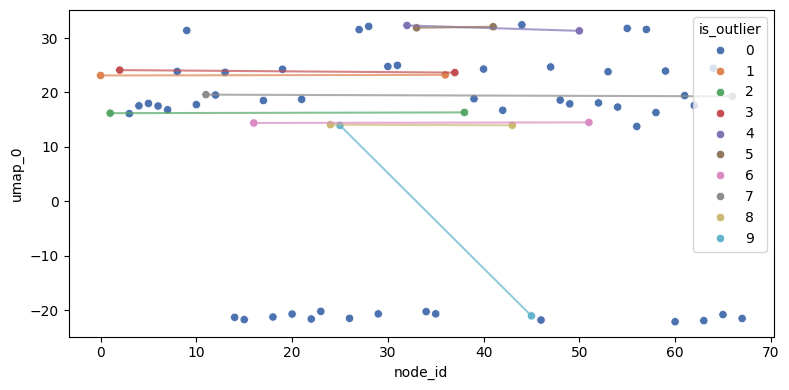

In [21]:
import umap

reduced = umap.UMAP(n_components=1).fit_transform(embeddings.embeddings_df.values[:, 1:])
x = embeddings.embeddings_df.iloc[:, 0]
y = reduced.flatten()
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.scatterplot(
    x=x,
    y=y,
    hue=features_df['is_outlier'],
    # hue=np.array(outlier_in_neighborhood)[egonet_sampled_nodes],
    ax=ax,
    palette='deep',
)
ax.set_xlabel("node_id")
ax.set_ylabel("umap_0")
for i in sorted(features_df.is_outlier.unique())[1:]:
    index = features_df.query(f'is_outlier=={i}').index.values
    ax.plot(x[index], y[index], color=palette[i], alpha=0.7)
    
fig.tight_layout()

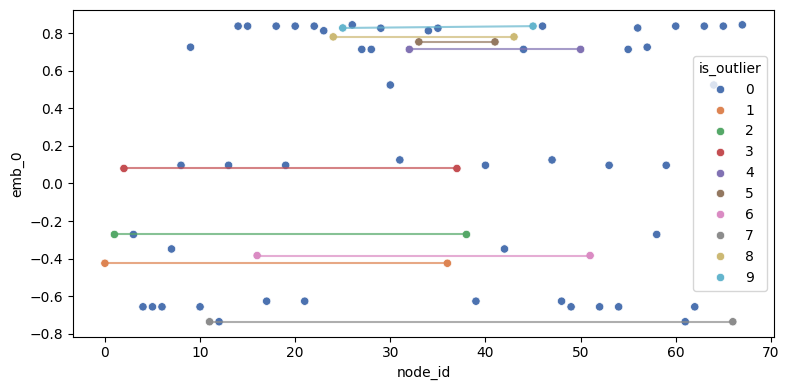

In [22]:
x = embeddings.embeddings_df.iloc[:, 0]
y = embeddings.embeddings_df.iloc[:, 3]
# reduced.flatten()
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.scatterplot(
    x=x,
    y=y,
    hue=features_df['is_outlier'],
    # hue=np.array(outlier_in_neighborhood)[egonet_sampled_nodes],
    ax=ax,
    palette='deep',
)
ax.set_xlabel("node_id")
ax.set_ylabel("emb_0")
for i in sorted(features_df.is_outlier.unique())[1:]:
    index = features_df.query(f'is_outlier=={i}').index.values
    ax.plot(x[index], y[index], color=palette[i], alpha=0.7)
    
    
fig.tight_layout()
